# Funnel Decomposition Analysis - Comprehensive Demo

This notebook demonstrates **all decomposition methodologies** available in the funnel decomposition package:

## Available Methods

1. **Symmetric Decomposition** (Order-independent midpoint methodology)
2. **Hierarchical Decomposition** (Sequential waterfall methodology)
3. **Weekly Analysis** (Using flexible date_column parameter)
4. **Multi-Lender Analysis** (Aggregate lender-level decomposition)

## Decomposition Effects

All methods decompose booking changes into 6 effects:
- **Volume Effect**: Change in total application volume
- **Mix Effect**: Change in segment distribution
- **Straight Approval Effect**: Change in straight approval rates
- **Conditional Approval Effect**: Change in conditional approval rates
- **Straight Booking Effect**: Change in straight booking rates
- **Conditional Booking Effect**: Change in conditional booking rates

## Shared Visualization Engine

All methods use the same visualization engine, producing:
- Waterfall grids (2×2 layout)
- Dimensional stacked waterfalls
- Dimension drilldown charts
- Multi-lender comparison charts

## Setup

In [1]:
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Add src to path
sys.path.insert(0, str(Path.cwd().parent / 'src'))

import symmetric_decomposition_calculator
import hier_decomposition_calculator
import visualization_engine

# Configure matplotlib for inline display
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['figure.dpi'] = 100

## Load Data

The dataset contains:
- **Time periods**: 24 months (2023-01-01 to 2024-12-01)
- **Lenders**: ACA, ALY, CAP
- **Dimensions**: FICO bands (High/Med/Low/Null), offer competition tier, product line
- **Funnel metrics**: Applications, approval rates, booking rates
- **Segments**: 24 segments per month per lender (4 FICO bands × 3 offer tiers × 2 product lines)

In [2]:
# Load monthly data
data_path = Path.cwd().parent / 'data' / 'funnel_data_mock_v2.csv'
df_monthly = pd.read_csv(data_path)
df_monthly['month_begin_date'] = pd.to_datetime(df_monthly['month_begin_date'])

print(f"Loaded {len(df_monthly)} rows of monthly data")
print(f"\nLenders: {', '.join(sorted(df_monthly['lender'].unique()))}")
print(f"Date range: {df_monthly['month_begin_date'].min().date()} to {df_monthly['month_begin_date'].max().date()}")
print(f"Unique months: {df_monthly['month_begin_date'].nunique()}")
print(f"Rows per month: {len(df_monthly) // df_monthly['month_begin_date'].nunique()}")

# Show sample
print("\nSample data:")
df_monthly.head(10)

Loaded 1728 rows of monthly data

Lenders: ACA, ALY, CAP
Date range: 2023-01-01 to 2024-12-01
Unique months: 24
Rows per month: 72

Sample data:


,lender,month_begin_date,fico_bands,offer_comp_tier,prod_line,num_tot_bks,num_tot_apps,pct_of_total_apps,str_apprv_rate,str_bk_rate,cond_apprv_rate,cond_bk_rate
0,ACA,2023-01-01,High_FICO,multi_best,Used,4480,15457,0.119658,0.511434,0.543518,0.274141,0.293948
1,ACA,2023-01-01,High_FICO,multi_best,VMax,4480,15457,0.076923,0.519058,0.562400,0.218179,0.238149
2,ACA,2023-01-01,High_FICO,multi_other,Used,4480,15457,0.064103,0.506125,0.553622,0.250533,0.252526
3,ACA,2023-01-01,High_FICO,multi_other,VMax,4480,15457,0.038462,0.519716,0.583189,0.271450,0.250301
4,ACA,2023-01-01,High_FICO,solo_offer,Used,4480,15457,0.145299,0.535860,0.494889,0.255789,0.307471
5,ACA,2023-01-01,High_FICO,solo_offer,VMax,4480,15457,0.094017,0.526114,0.522786,0.262885,0.274057
6,ACA,2023-01-01,Low_FICO,multi_best,Used,4480,15457,0.031624,0.293352,0.368758,0.406648,0.174373
7,ACA,2023-01-01,Low_FICO,multi_best,VMax,4480,15457,0.015385,0.291933,0.384067,0.408067,0.190754
8,ACA,2023-01-01,Low_FICO,multi_other,Used,4480,15457,0.015385,0.296742,0.312354,0.403258,0.171332
9,ACA,2023-01-01,Low_FICO,multi_other,VMax,4480,15457,0.007692,0.267162,0.404380,0.432838,0.161063


---

# 1. Symmetric Decomposition (Order-Independent)

## Methodology

**Symmetric decomposition** uses a **midpoint approach** where all effects are calculated independently using **average values** from both periods:

1. **Volume Effect**: `ΔA × p_avg × conversion_avg`
2. **Mix Effect**: `A_avg × Δp × conversion_avg`
3. **Straight Approval Effect**: `A_avg × p_avg × Δr_str × b_str_avg`
4. **Conditional Approval Effect**: `A_avg × p_avg × Δr_cond × b_cond_avg`
5. **Straight Booking Effect**: `A_avg × p_avg × r_str_avg × Δb_str`
6. **Conditional Booking Effect**: `A_avg × p_avg × r_cond_avg × Δb_cond`
7. **Interaction Effect**: Residual to ensure perfect reconciliation

Where `_avg = (value_1 + value_2) / 2`

## Key Advantages

- **Order-independent**: Effect order doesn't matter
- **Balanced**: No bias toward either period
- **Perfect reconciliation**: Includes interaction effect
- **Consistent**: Same results regardless of calculation sequence

In [3]:
# Calculate symmetric decomposition for June 2023 → June 2024 (YoY)
results_sym = symmetric_decomposition_calculator.calculate_decomposition(
    df=df_monthly,
    date_a='2023-06-01',
    date_b='2024-06-01',
    lender='ACA'
)

print("Symmetric Decomposition Results:")
print(f"  Method: {results_sym.metadata['method']}")
print(f"  Period 1: {results_sym.metadata['date_a']}")
print(f"  Period 2: {results_sym.metadata['date_b']}")
print(f"  Period 1 bookings: {results_sym.metadata['period_1_total_bookings']:,.0f}")
print(f"  Period 2 bookings: {results_sym.metadata['period_2_total_bookings']:,.0f}")
print(f"  Delta bookings: {results_sym.metadata['delta_total_bookings']:+,.0f}")
print(f"  Number of segments: {results_sym.metadata['num_segments']}")

Symmetric Decomposition Results:
  Method: symmetric
  Period 1: 2023-06-01
  Period 2: 2024-06-01
  Period 1 bookings: 5,092
  Period 2 bookings: 5,187
  Delta bookings: +95
  Number of segments: 24


In [4]:
# View summary
print("\nSymmetric Decomposition Summary:")
results_sym.summary


Symmetric Decomposition Summary:


,effect_type,booking_impact
0,volume_effect,911.342282
1,mix_effect,0.000000
2,str_approval_effect,12.324957
3,cond_approval_effect,47.285843
4,str_booking_effect,-688.945317
5,cond_booking_effect,-186.435663
6,interaction_effect,-0.572102
7,total_change,95.000000


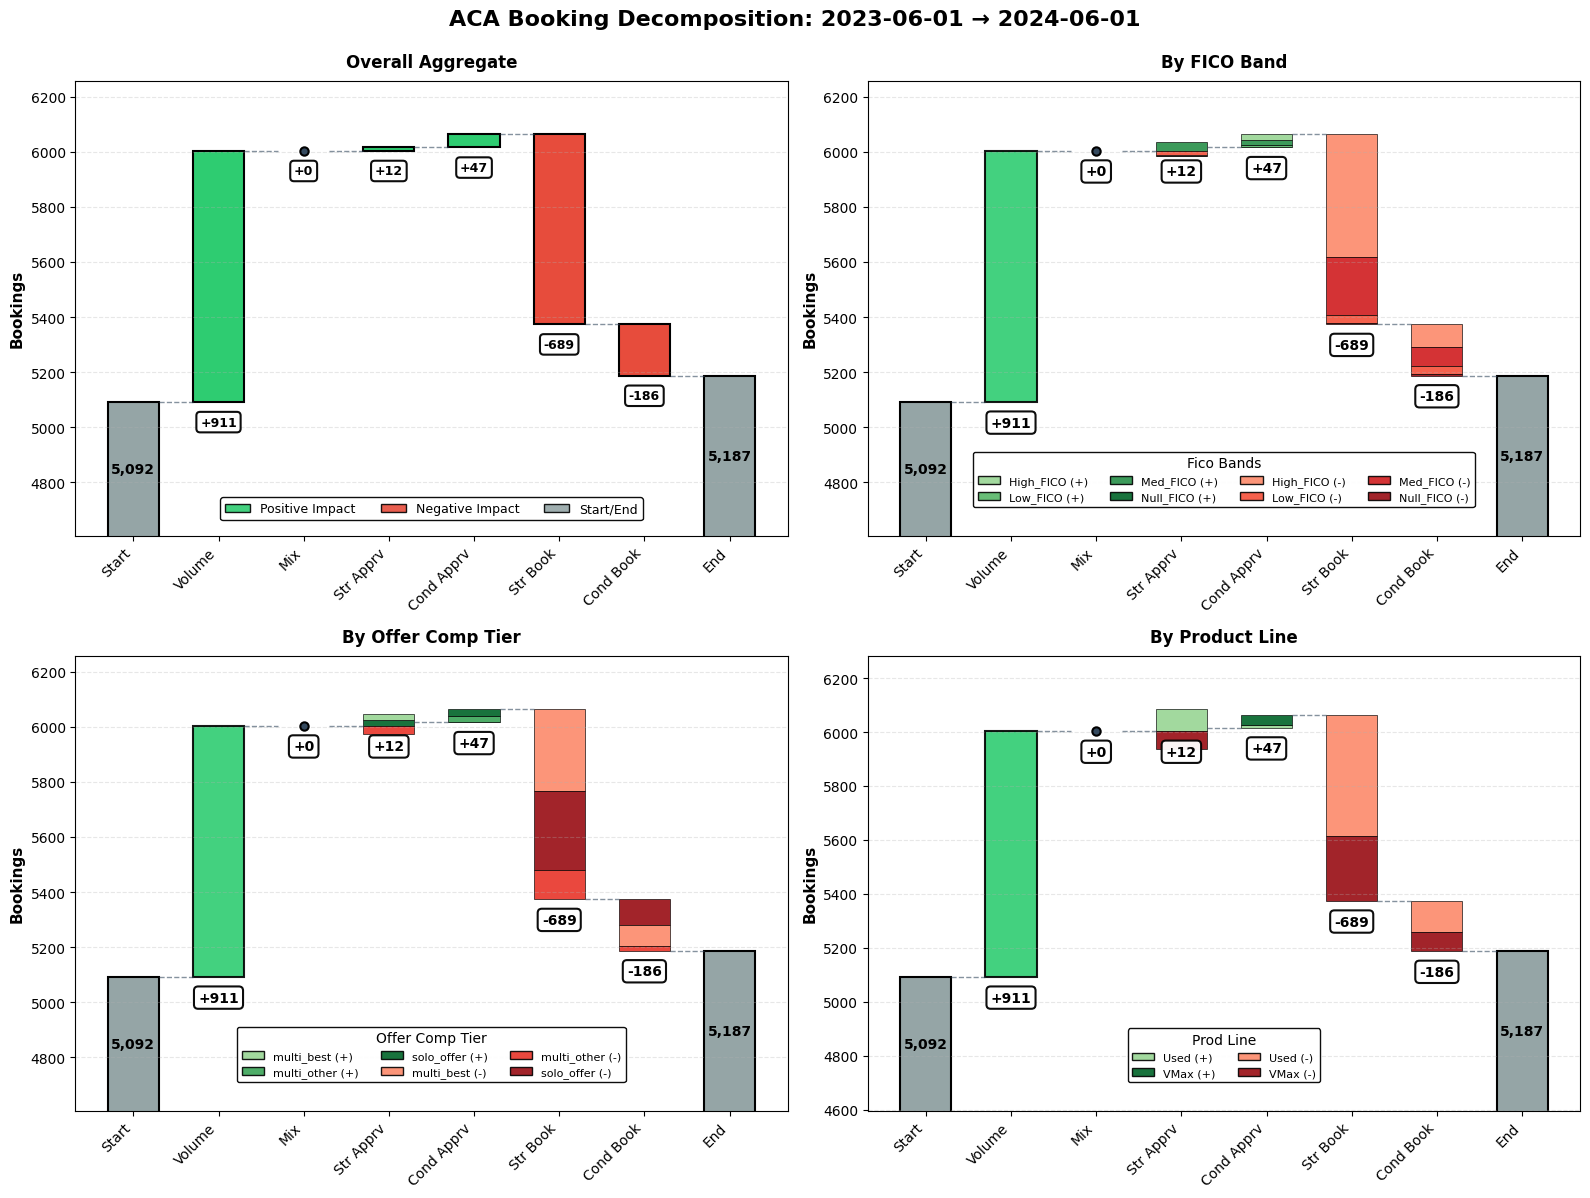

In [5]:
# Create waterfall grid visualization
fig_sym = visualization_engine.create_waterfall_grid(
    summary=results_sym.summary,
    segment_detail=results_sym.segment_detail,
    lender='ACA'
)

plt.show()

---

# 2. Hierarchical Decomposition (Sequential Waterfall)

## Methodology

**Hierarchical decomposition** uses a **sequential waterfall** where each effect builds on previous steps:

1. **Volume Effect**: `ΔA × p[1] × conversion[1]` (using Period 1 values)
2. **Mix Effect**: `A[2] × Δp × conversion[1]` (using new apps, Period 1 rates)
3. **Straight Approval Effect**: `A[2] × p[2] × Δr_str × b_str[1]`
4. **Conditional Approval Effect**: `A[2] × p[2] × Δr_cond × b_cond[1]`
5. **Straight Booking Effect**: `A[2] × p[2] × r_str[2] × Δb_str`
6. **Conditional Booking Effect**: `A[2] × p[2] × r_cond[2] × Δb_cond`

## Key Advantages

- **Sequential logic**: Mirrors step-by-step business changes
- **Interpretable**: Each effect shows incremental impact
- **Perfect reconciliation**: No residual interaction effect needed
- **Traditional**: Familiar waterfall approach

In [6]:
# Calculate hierarchical decomposition for same period
results_hier = hier_decomposition_calculator.calculate_decomposition(
    df=df_monthly,
    date_a='2023-06-01',
    date_b='2024-06-01',
    lender='ACA'
)

print("Hierarchical Decomposition Results:")
print(f"  Period 1: {results_hier.metadata['date_a']}")
print(f"  Period 2: {results_hier.metadata['date_b']}")
print(f"  Period 1 bookings: {results_hier.metadata['period_1_total_bookings']:,.0f}")
print(f"  Period 2 bookings: {results_hier.metadata['period_2_total_bookings']:,.0f}")
print(f"  Delta bookings: {results_hier.metadata['delta_total_bookings']:+,.0f}")
print(f"  Number of segments: {results_hier.metadata['num_segments']}")

Hierarchical Decomposition Results:
  Period 1: 2023-06-01
  Period 2: 2024-06-01
  Period 1 bookings: 5,092
  Period 2 bookings: 5,187
  Delta bookings: +95
  Number of segments: 24


In [7]:
# View summary
print("\nHierarchical Decomposition Summary:")
results_hier.summary


Hierarchical Decomposition Summary:


,effect_type,booking_impact
0,volume_effect,982.550196
1,mix_effect,0.000000
2,str_approval_effect,16.202617
3,cond_approval_effect,55.727329
4,str_booking_effect,-752.359133
5,cond_booking_effect,-207.121009
6,total_change,95.000000


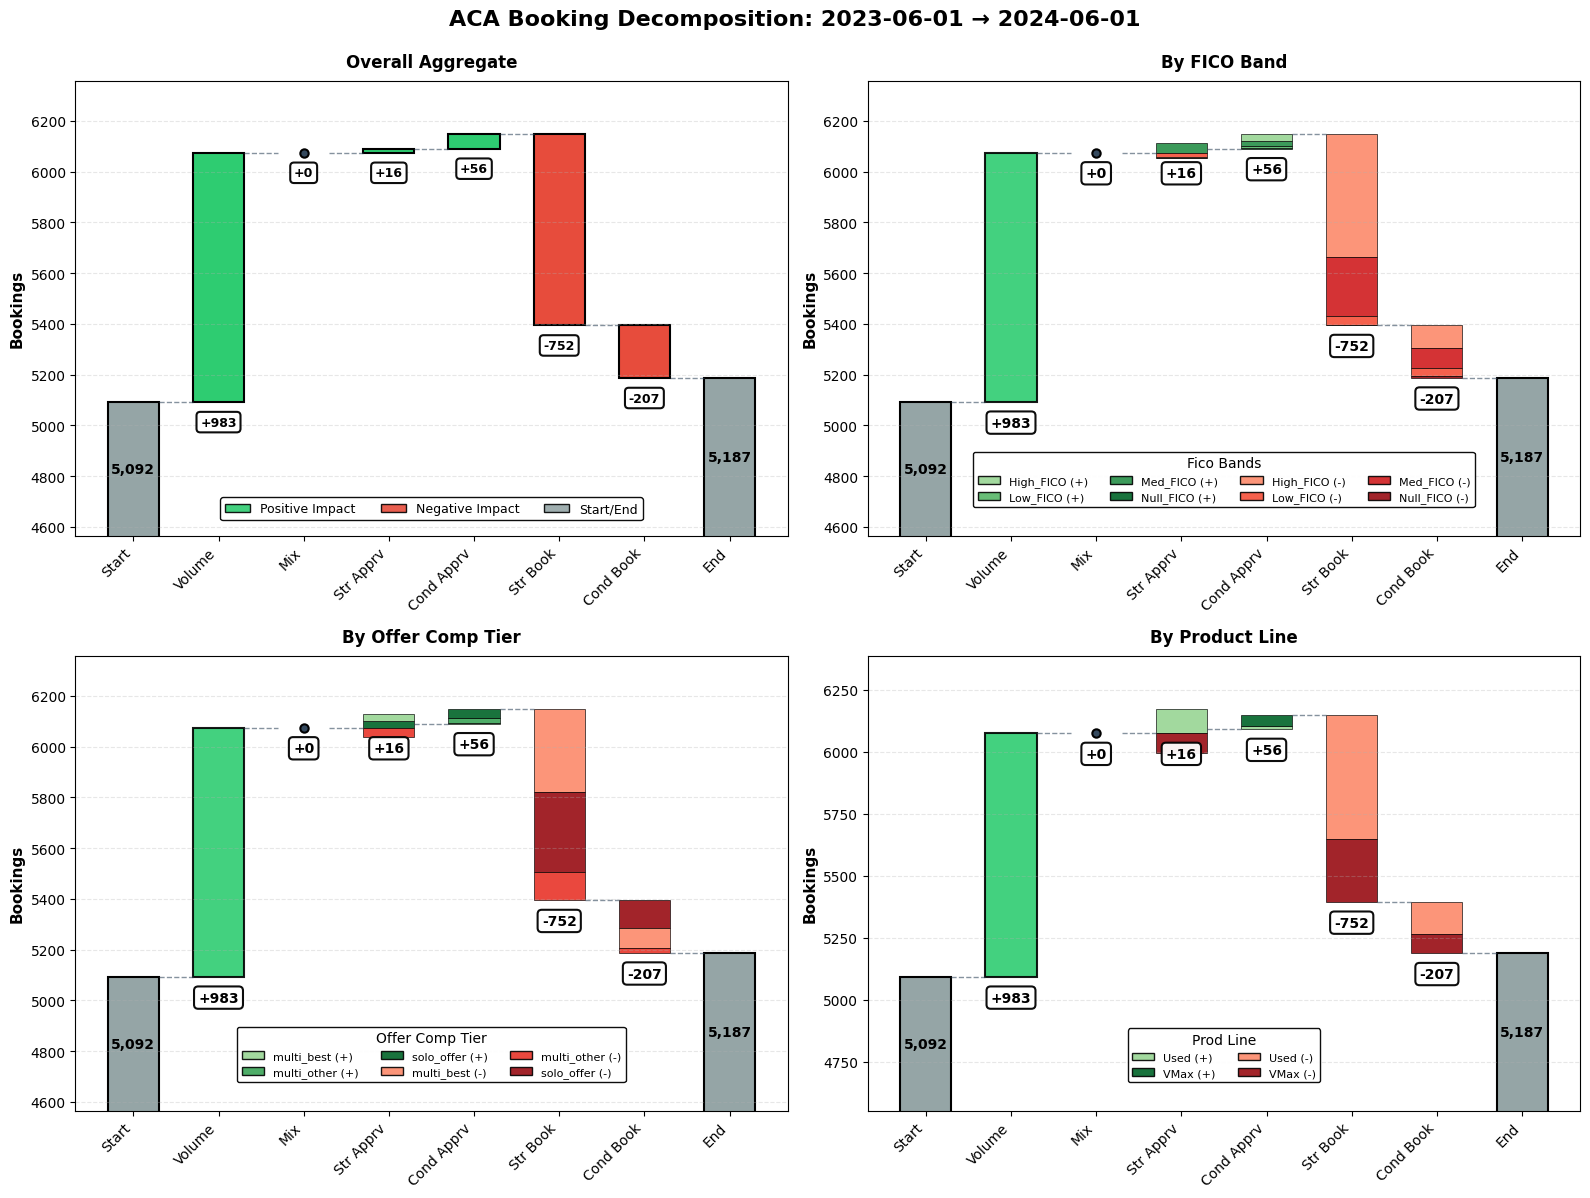

In [8]:
# Create waterfall grid visualization
fig_hier = visualization_engine.create_waterfall_grid(
    summary=results_hier.summary,
    segment_detail=results_hier.segment_detail,
    lender='ACA'
)

plt.show()

## Compare Symmetric vs Hierarchical

Let's compare the two methodologies side-by-side:

In [9]:
# Create comparison table
comparison = pd.merge(
    results_sym.summary,
    results_hier.summary,
    on='effect_type',
    suffixes=('_symmetric', '_hierarchical')
)
comparison['difference'] = comparison['booking_impact_symmetric'] - comparison['booking_impact_hierarchical']
comparison['pct_difference'] = (comparison['difference'] / comparison['booking_impact_hierarchical'].abs() * 100).round(1)

print("\nSymmetric vs Hierarchical Comparison:")
print("=" * 100)
comparison


Symmetric vs Hierarchical Comparison:


,effect_type,booking_impact_symmetric,booking_impact_hierarchical,difference,pct_difference
0,volume_effect,911.342282,982.550196,-7.120791e+01,-7.2
1,mix_effect,0.000000,0.000000,0.000000e+00,NaN
2,str_approval_effect,12.324957,16.202617,-3.877661e+00,-23.9
3,cond_approval_effect,47.285843,55.727329,-8.441486e+00,-15.1
4,str_booking_effect,-688.945317,-752.359133,6.341382e+01,8.4
5,cond_booking_effect,-186.435663,-207.121009,2.068535e+01,10.0
6,total_change,95.000000,95.000000,-1.278977e-13,-0.0


---

# 3. Weekly Analysis (Using date_column Parameter)

## New Feature: Flexible Date Column

All calculators now support a **`date_column` parameter** that allows you to:
- Analyze weekly data without renaming columns
- Use custom date column names
- Keep your code explicit and clear

**Default**: `date_column='month_begin_date'` (backward compatible)

## Weekly Data Example

In [10]:
# Load weekly data
weekly_path = Path.cwd().parent / 'data' / 'funnel_data_mock_weekly.csv'
df_weekly = pd.read_csv(weekly_path)
df_weekly['week_begin_date'] = pd.to_datetime(df_weekly['week_begin_date'])

print(f"Loaded {len(df_weekly)} rows of weekly data")
print(f"\nDate range: {df_weekly['week_begin_date'].min().date()} to {df_weekly['week_begin_date'].max().date()}")
print(f"Unique weeks: {df_weekly['week_begin_date'].nunique()}")
print(f"Segments per week: {len(df_weekly) // df_weekly['week_begin_date'].nunique()}")

Loaded 2496 rows of weekly data

Date range: 2023-01-02 to 2024-12-23
Unique weeks: 104
Segments per week: 24


In [11]:
# Select weeks for analysis (Week 26 vs Week 78 = ~1 year apart)
unique_weeks = sorted(df_weekly['week_begin_date'].unique())
week_1 = unique_weeks[25]  # Week 26
week_2 = unique_weeks[77]  # Week 78

print(f"Comparing:")
print(f"  Week 1: {week_1.date()}")
print(f"  Week 2: {week_2.date()}")
print(f"  Time span: {(week_2 - week_1).days} days (~{(week_2 - week_1).days // 7} weeks)")

Comparing:
  Week 1: 2023-06-26
  Week 2: 2024-06-24
  Time span: 364 days (~52 weeks)


In [12]:
# Calculate symmetric decomposition with date_column parameter
results_weekly = symmetric_decomposition_calculator.calculate_decomposition(
    df=df_weekly,
    date_a=week_1,
    date_b=week_2,
    lender='ACA',
    date_column='week_begin_date'  # NEW: Specify the date column directly!
)

print("Weekly Symmetric Decomposition Results:")
print(f"  Method: {results_weekly.metadata['method']}")
print(f"  Period 1: {results_weekly.metadata['date_a']}")
print(f"  Period 2: {results_weekly.metadata['date_b']}")
print(f"  Period 1 bookings: {results_weekly.metadata['period_1_total_bookings']:,.0f}")
print(f"  Period 2 bookings: {results_weekly.metadata['period_2_total_bookings']:,.0f}")
print(f"  Delta bookings: {results_weekly.metadata['delta_total_bookings']:+,.0f}")
print(f"\nSummary:")
results_weekly.summary

Weekly Symmetric Decomposition Results:
  Method: symmetric
  Period 1: 2023-06-26
  Period 2: 2024-06-24
  Period 1 bookings: 1,044
  Period 2 bookings: 1,309
  Delta bookings: +265

Summary:


,effect_type,booking_impact
0,volume_effect,244.562571
1,mix_effect,0.000000
2,str_approval_effect,35.178494
3,cond_approval_effect,-13.789016
4,str_booking_effect,-3.952251
5,cond_booking_effect,3.164962
6,interaction_effect,-0.164760
7,total_change,265.000000


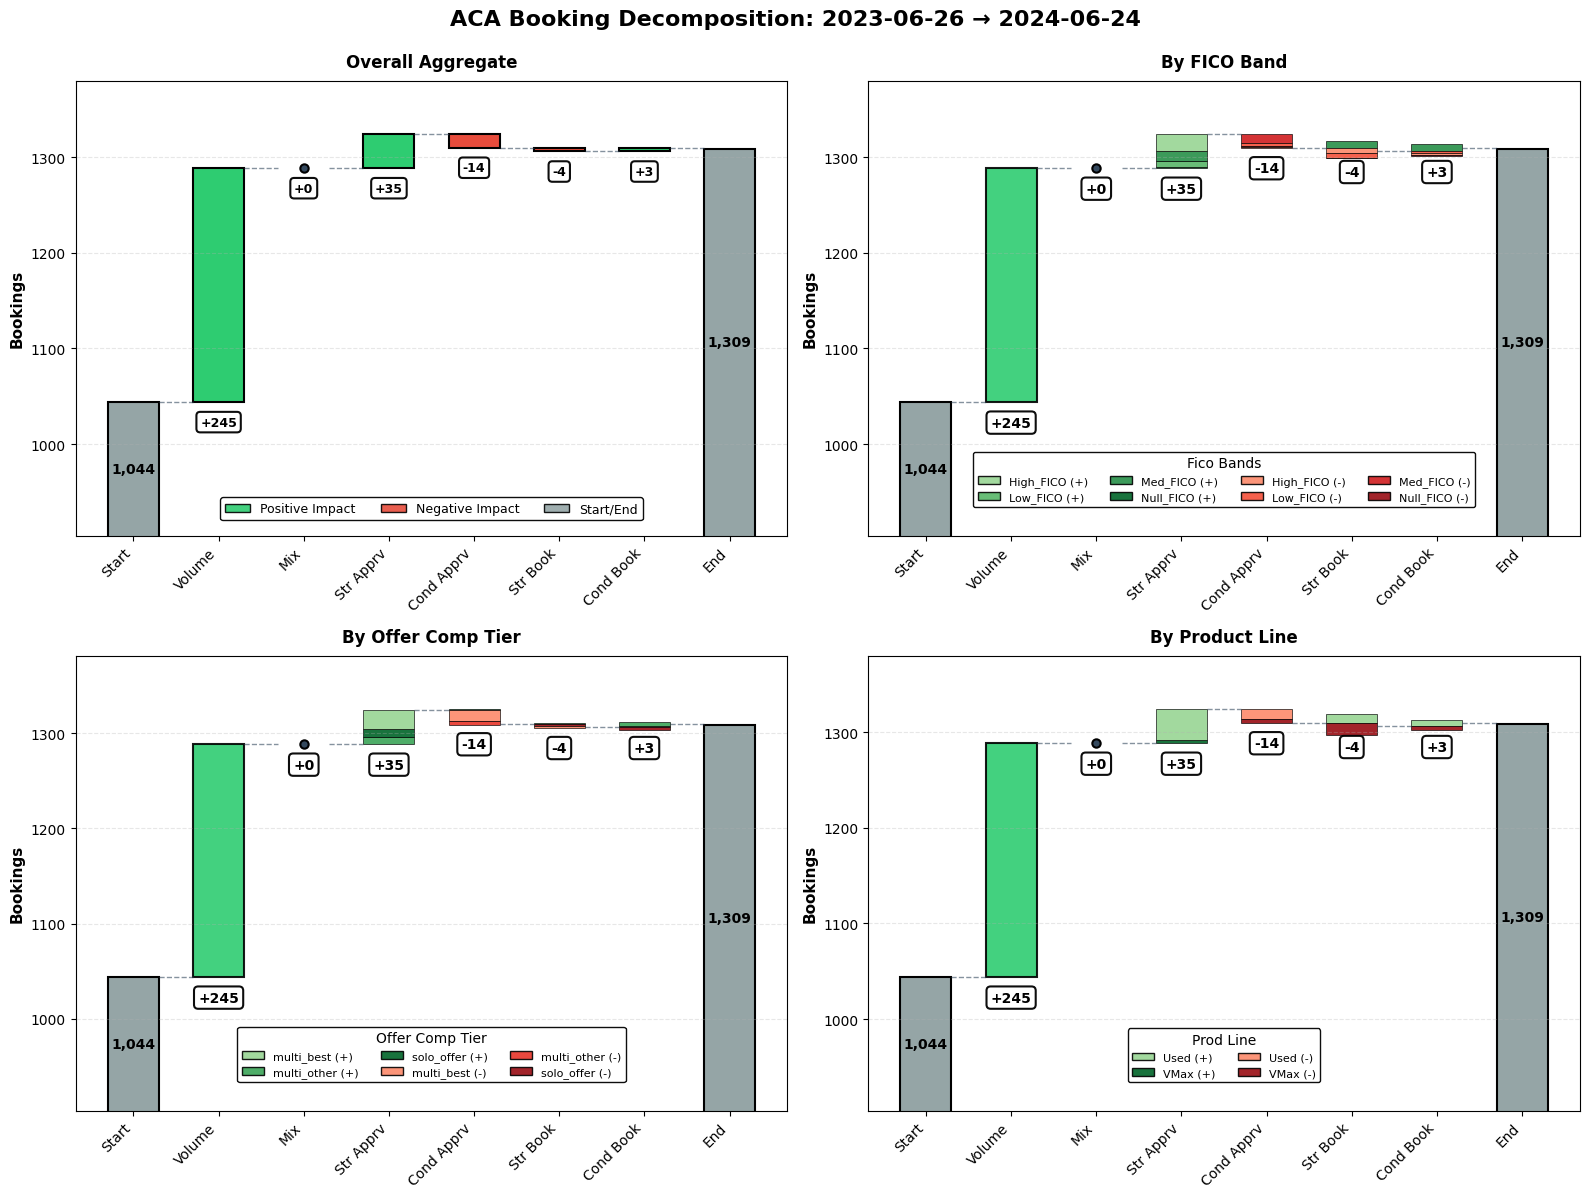

In [13]:
# Create waterfall grid for weekly data
fig_weekly = visualization_engine.create_waterfall_grid(
    summary=results_weekly.summary,
    segment_detail=results_weekly.segment_detail,
    lender='ACA'
)

plt.show()

## Weekly Trend Analysis (Bonus)

With weekly data, we can analyze trends over time:

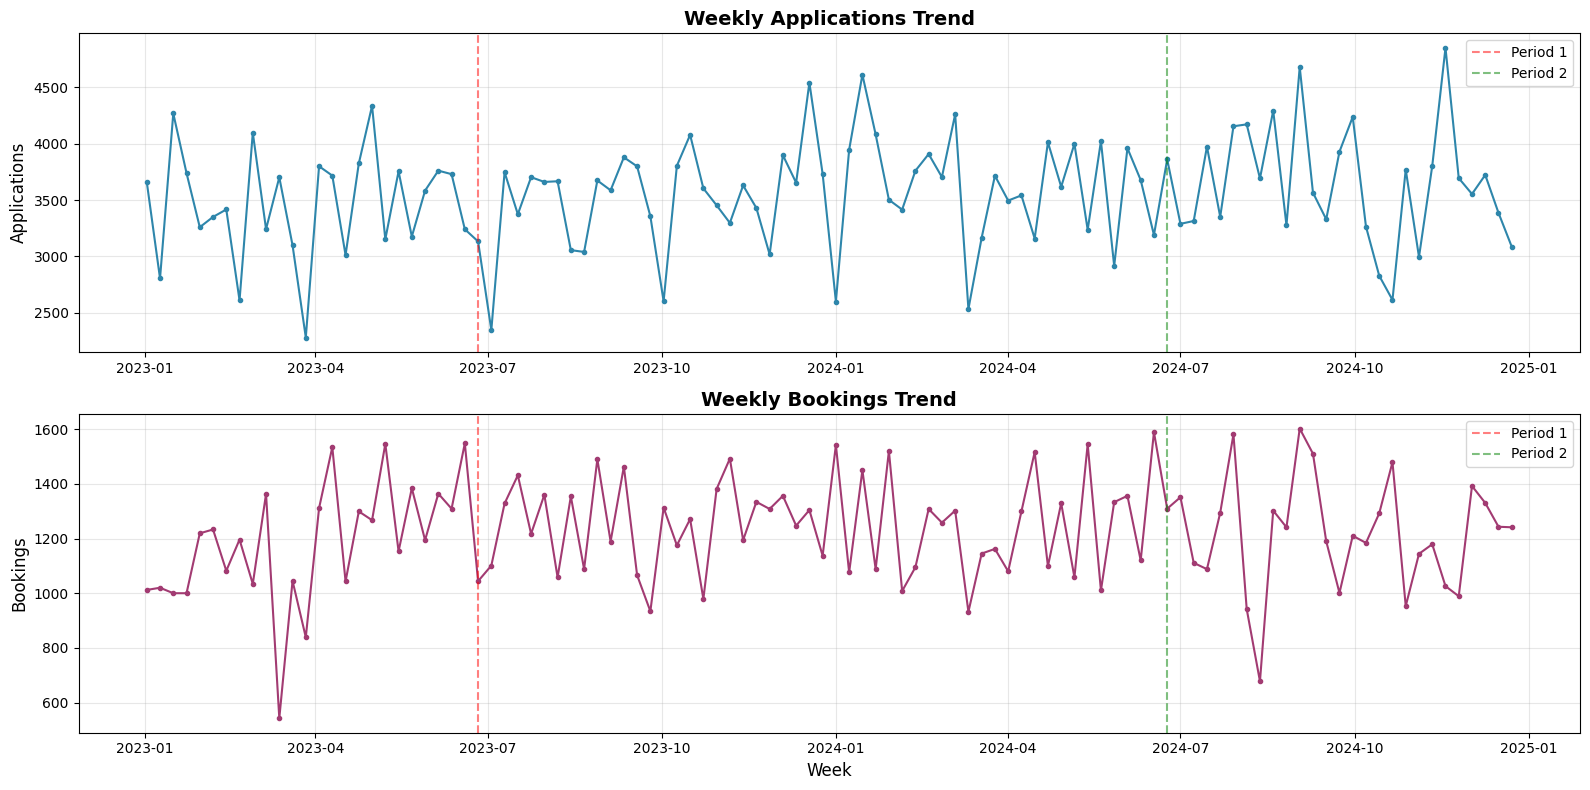

In [14]:
# Calculate weekly totals
weekly_totals = df_weekly.groupby('week_begin_date').agg({
    'num_tot_apps': 'first',
    'num_tot_bks': 'first'
}).reset_index()

# Create trend plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8))

# Applications trend
ax1.plot(weekly_totals['week_begin_date'], weekly_totals['num_tot_apps'], 
         marker='o', markersize=3, linewidth=1.5, color='#2E86AB')
ax1.set_title('Weekly Applications Trend', fontsize=14, fontweight='bold')
ax1.set_ylabel('Applications', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.axvline(week_1, color='red', linestyle='--', alpha=0.5, label='Period 1')
ax1.axvline(week_2, color='green', linestyle='--', alpha=0.5, label='Period 2')
ax1.legend()

# Bookings trend
ax2.plot(weekly_totals['week_begin_date'], weekly_totals['num_tot_bks'], 
         marker='o', markersize=3, linewidth=1.5, color='#A23B72')
ax2.set_title('Weekly Bookings Trend', fontsize=14, fontweight='bold')
ax2.set_ylabel('Bookings', fontsize=12)
ax2.set_xlabel('Week', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.axvline(week_1, color='red', linestyle='--', alpha=0.5, label='Period 1')
ax2.axvline(week_2, color='green', linestyle='--', alpha=0.5, label='Period 2')
ax2.legend()

plt.tight_layout()
plt.show()

---

# 4. Multi-Lender Analysis

## Multi-Lender Decomposition

Analyze multiple lenders simultaneously with:
- **Aggregate view**: Overall performance across all lenders
- **Lender attribution**: See which lender drives each effect
- **Side-by-side comparison**: Overall vs by-lender breakdowns

This is useful for:
- Portfolio management
- Lender comparison and benchmarking
- Strategic resource allocation
- Root cause analysis (lender-specific vs systematic)

In [15]:
# Calculate multi-lender decomposition
results_multi = symmetric_decomposition_calculator.calculate_multi_lender_decomposition(
    df=df_monthly,
    date_a='2023-06-01',
    date_b='2024-06-01'
)

print("Multi-Lender Symmetric Decomposition Results:")
print(f"  Method: {results_multi.metadata['method']}")
print(f"  Period 1: {results_multi.metadata['date_a']}")
print(f"  Period 2: {results_multi.metadata['date_b']}")
print(f"  Lenders analyzed: {', '.join(results_multi.metadata['lenders'])}")
print(f"\nAggregate Results (All Lenders):")
print(f"  Period 1 bookings: {results_multi.metadata['aggregate_period_1_bookings']:,.0f}")
print(f"  Period 2 bookings: {results_multi.metadata['aggregate_period_2_bookings']:,.0f}")
print(f"  Delta bookings: {results_multi.metadata['aggregate_delta_bookings']:+,.0f}")

Calculating decomposition for ACA...
Calculating decomposition for ALY...
Calculating decomposition for CAP...
Multi-Lender Symmetric Decomposition Results:
  Method: symmetric_multi_lender
  Period 1: 2023-06-01
  Period 2: 2024-06-01
  Lenders analyzed: ACA, ALY, CAP

Aggregate Results (All Lenders):
  Period 1 bookings: 9,736
  Period 2 bookings: 9,885
  Delta bookings: +149


In [16]:
# View aggregate summary
print("\nAggregate Summary (All Lenders):")
results_multi.aggregate_summary


Aggregate Summary (All Lenders):


,effect_type,booking_impact
0,volume_effect,1286.552682
1,mix_effect,0.000000
2,str_approval_effect,44.984303
3,cond_approval_effect,94.998891
4,str_booking_effect,-1028.905037
5,cond_booking_effect,-247.678116
6,interaction_effect,-0.952723
7,total_change,149.000000


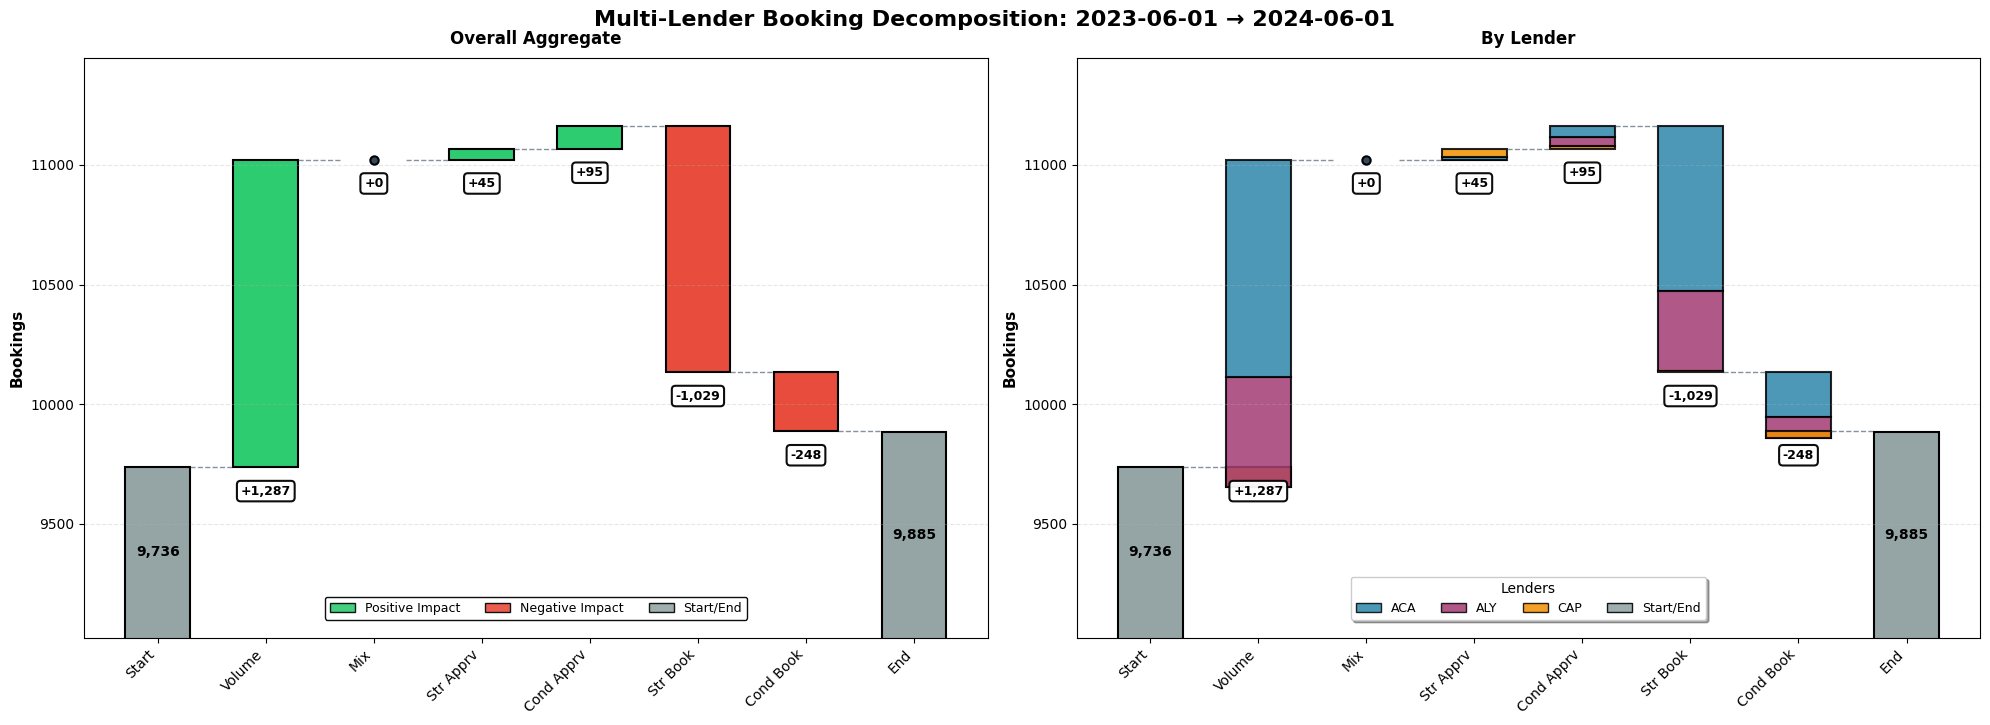

In [17]:
# Create lender waterfall grid (2-panel: Overall vs By Lender)
fig_multi = visualization_engine.create_lender_waterfall_grid(
    lender_summaries=results_multi.lender_summaries,
    aggregate_summary=results_multi.aggregate_summary,
    metadata=results_multi.metadata
)

plt.show()

In [18]:
# Print lender-level breakdowns
visualization_engine.print_lender_breakdowns(results_multi.lender_summaries)

LENDER-LEVEL BREAKDOWN

lender             ACA         ALY        CAP        TOTAL
Cond Apprv   47.285843   36.483411  11.229636    94.998891
Cond Book  -186.435663  -88.222376  26.979923  -247.678116
Mix           0.000000    0.000000   0.000000     0.000000
Str Apprv    12.324957   -3.622235  36.281581    44.984303
Str Book   -688.945317 -336.614376  -3.345344 -1028.905037
Volume      911.342282  458.341013 -83.130613  1286.552682


TOTAL CHANGE BY LENDER:
----------------------------------------
  ACA: +95
  ALY: +66
  CAP: -12

  GRAND TOTAL: +149


/home/granty1231/funnel_decomposition/src/visualization_engine.py:1132: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(-x_max, x_max)


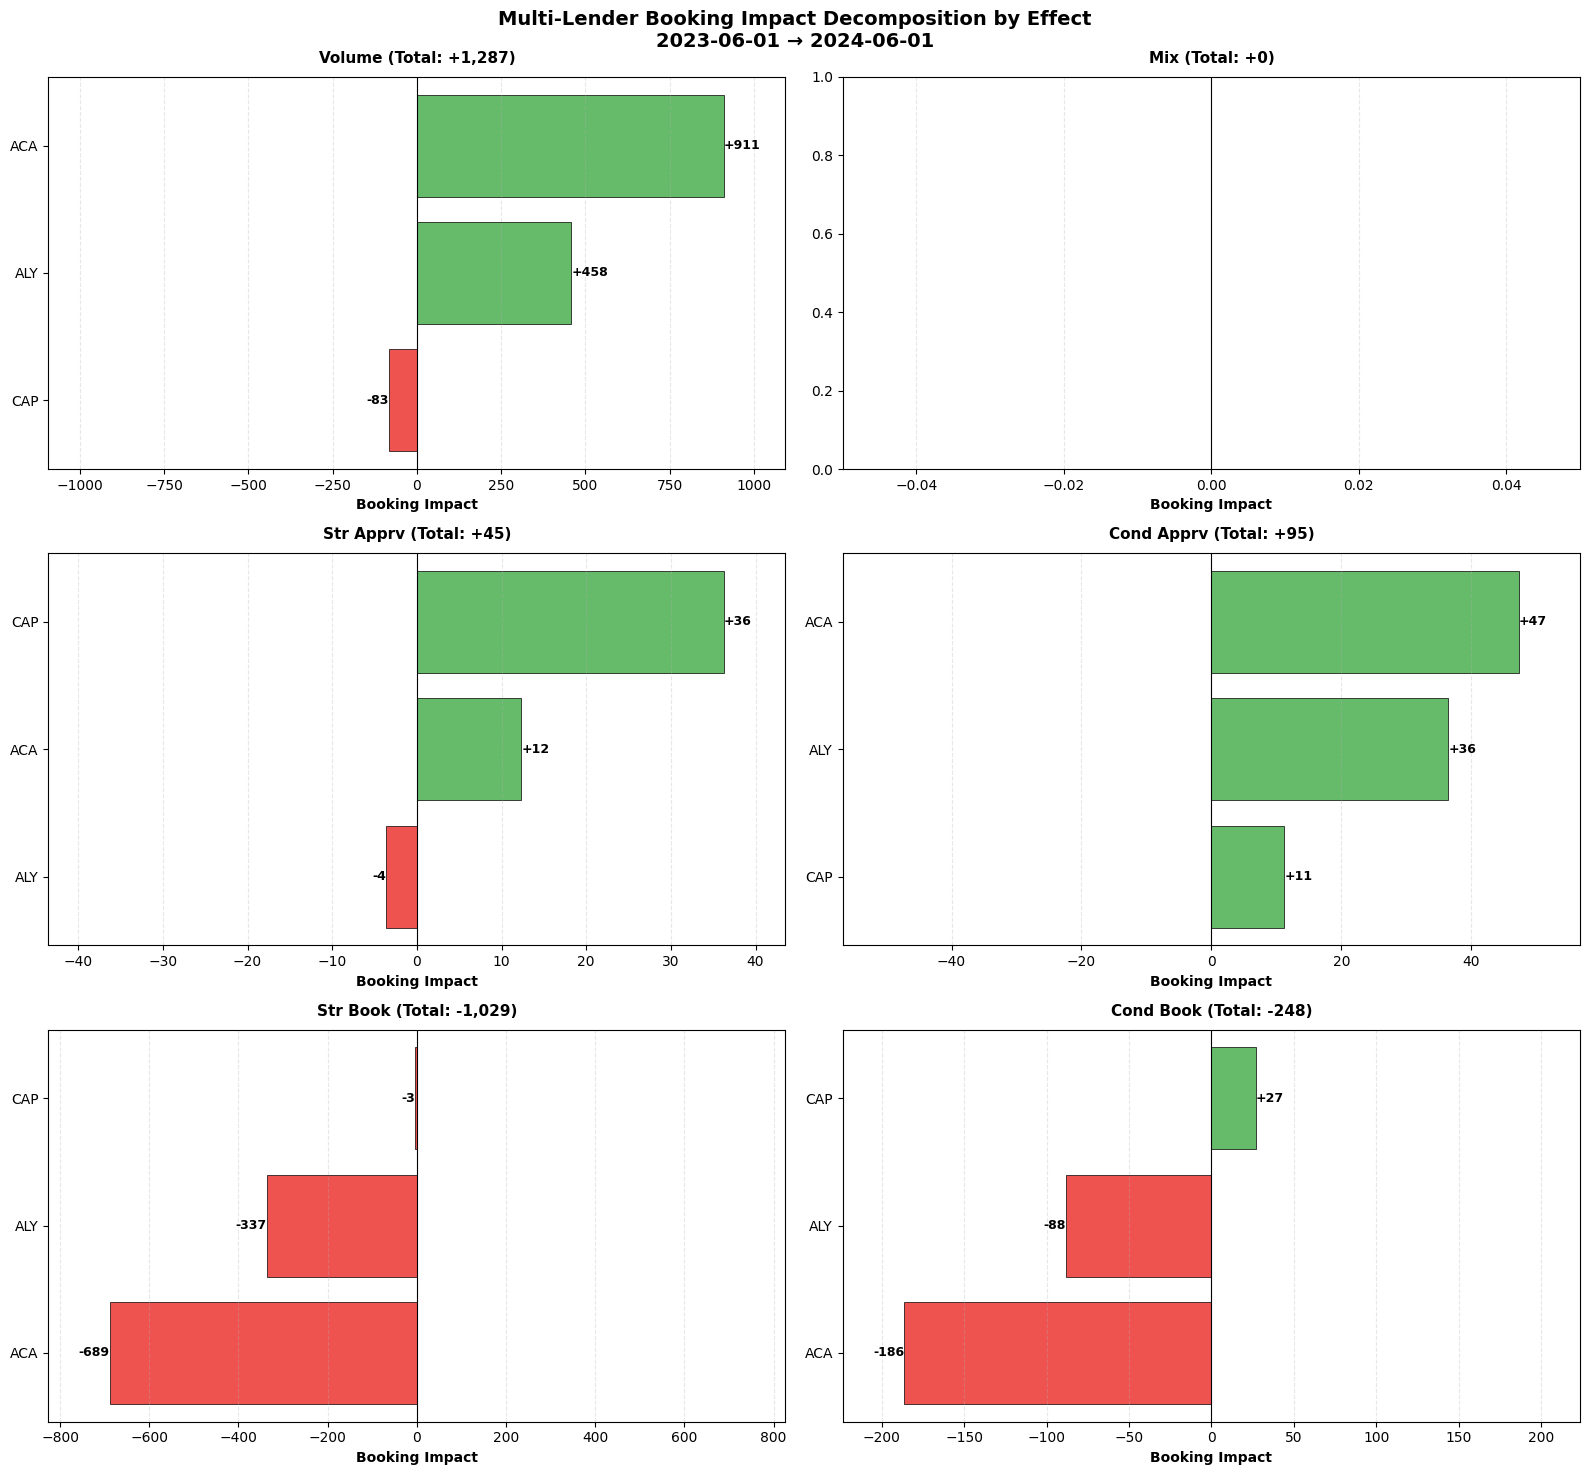

In [19]:
# Create lender drilldown (each effect broken down by lender)
fig_lender_drill = visualization_engine.create_lender_drilldown(
    lender_summaries=results_multi.lender_summaries,
    date_a=results_multi.metadata['date_a'],
    date_b=results_multi.metadata['date_b']
)

plt.show()

---

# 5. Dimension Drilldowns

## Detailed Analysis by Dimension

For any decomposition result, you can create drilldown charts showing each effect broken down by:
- FICO bands (High/Med/Low/Null)
- Offer competition tier (solo_offer/multi_best/multi_other)
- Product line (Used/VMax)

### Example: FICO Band Drilldown

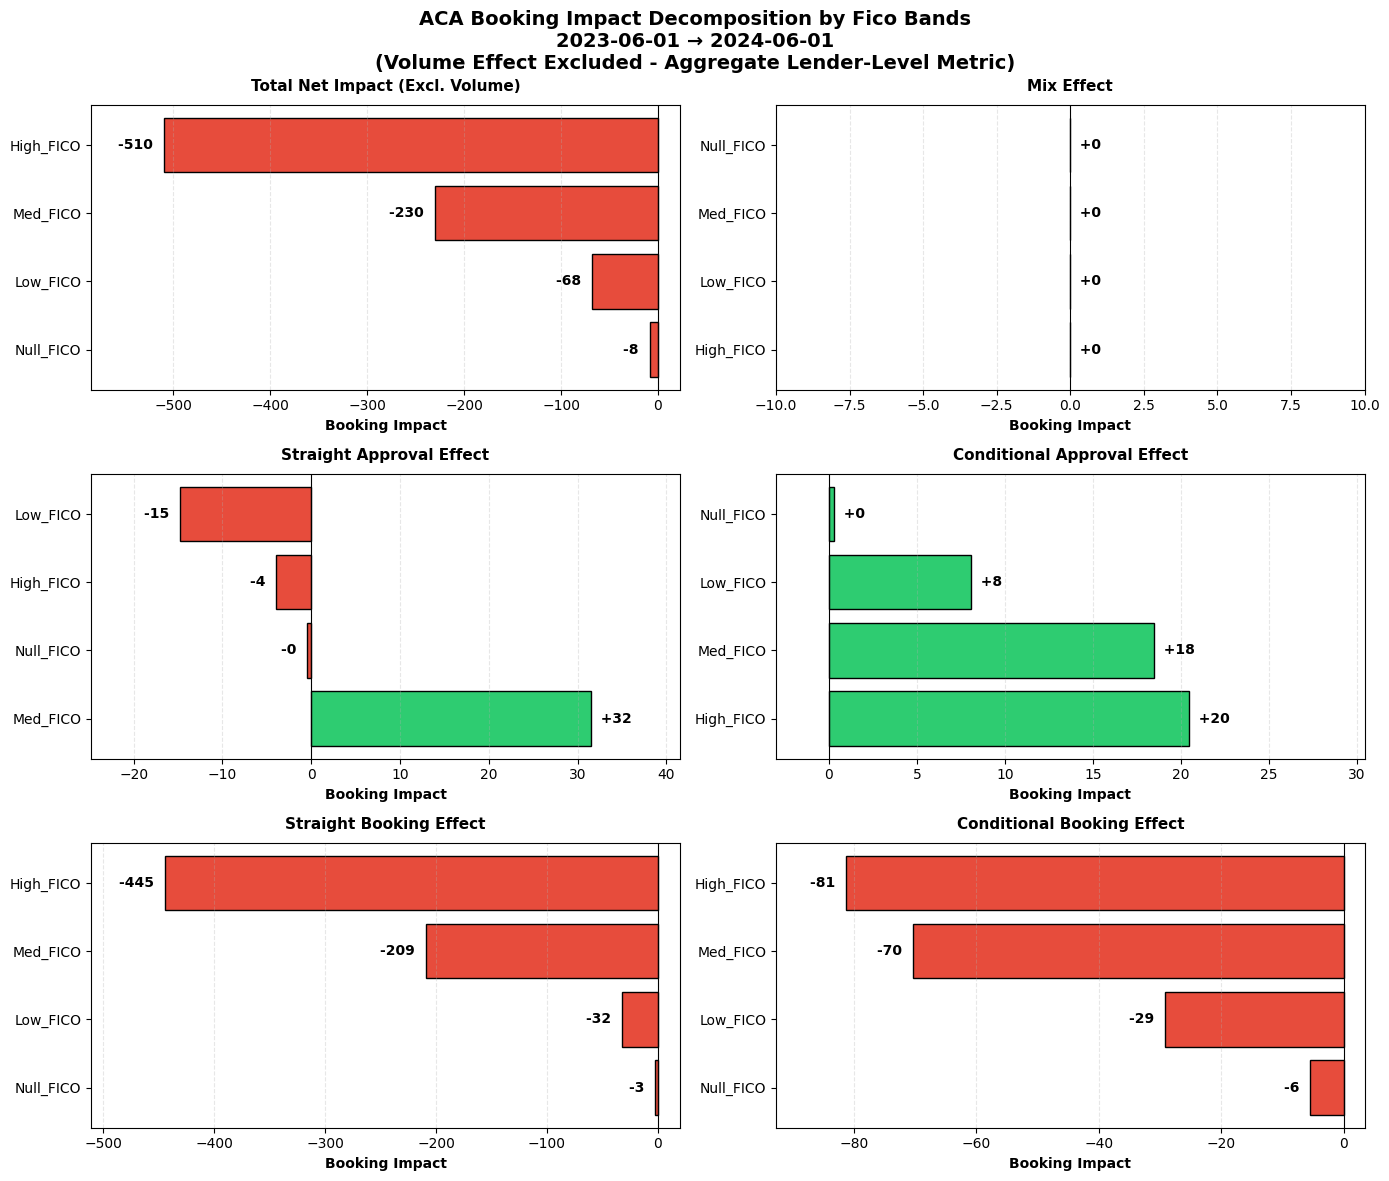

In [20]:
# Create FICO band drilldown
fig_fico = visualization_engine.create_dimension_drilldown(
    segment_detail=results_sym.segment_detail,
    dimension='fico_bands',
    lender='ACA'
)

plt.show()

### Example: Offer Comp Tier Drilldown

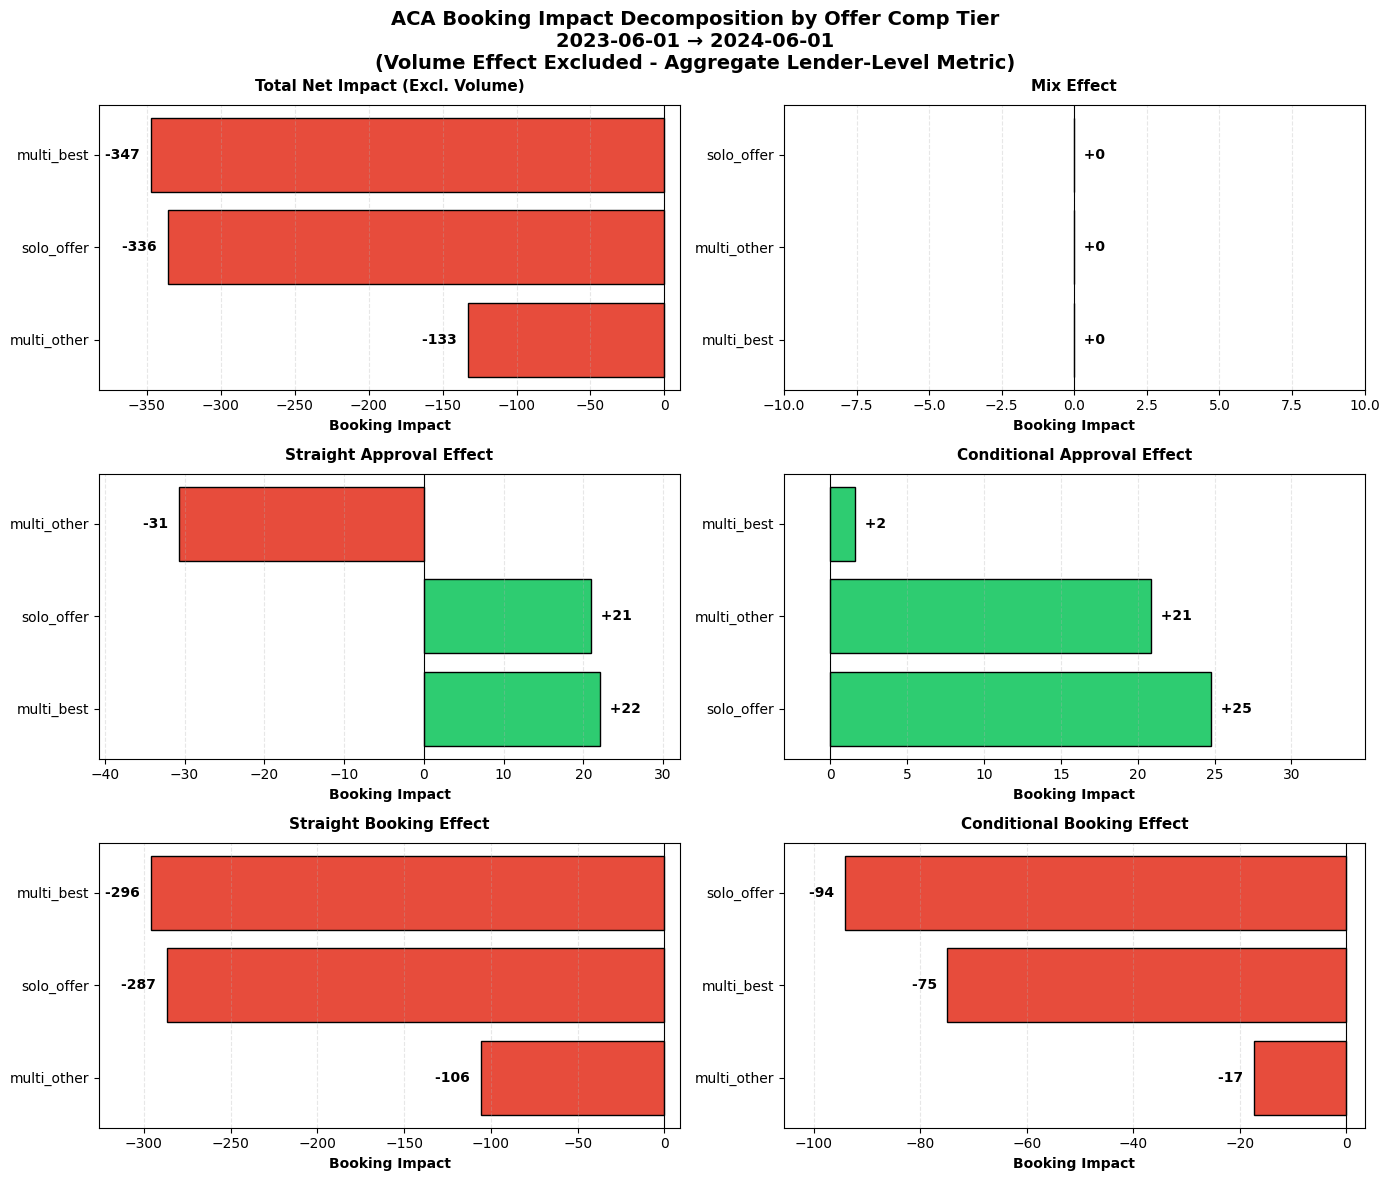

In [21]:
# Create Offer Comp Tier drilldown
fig_comp = visualization_engine.create_dimension_drilldown(
    segment_detail=results_sym.segment_detail,
    dimension='offer_comp_tier',
    lender='ACA'
)

plt.show()

### Example: Product Line Drilldown

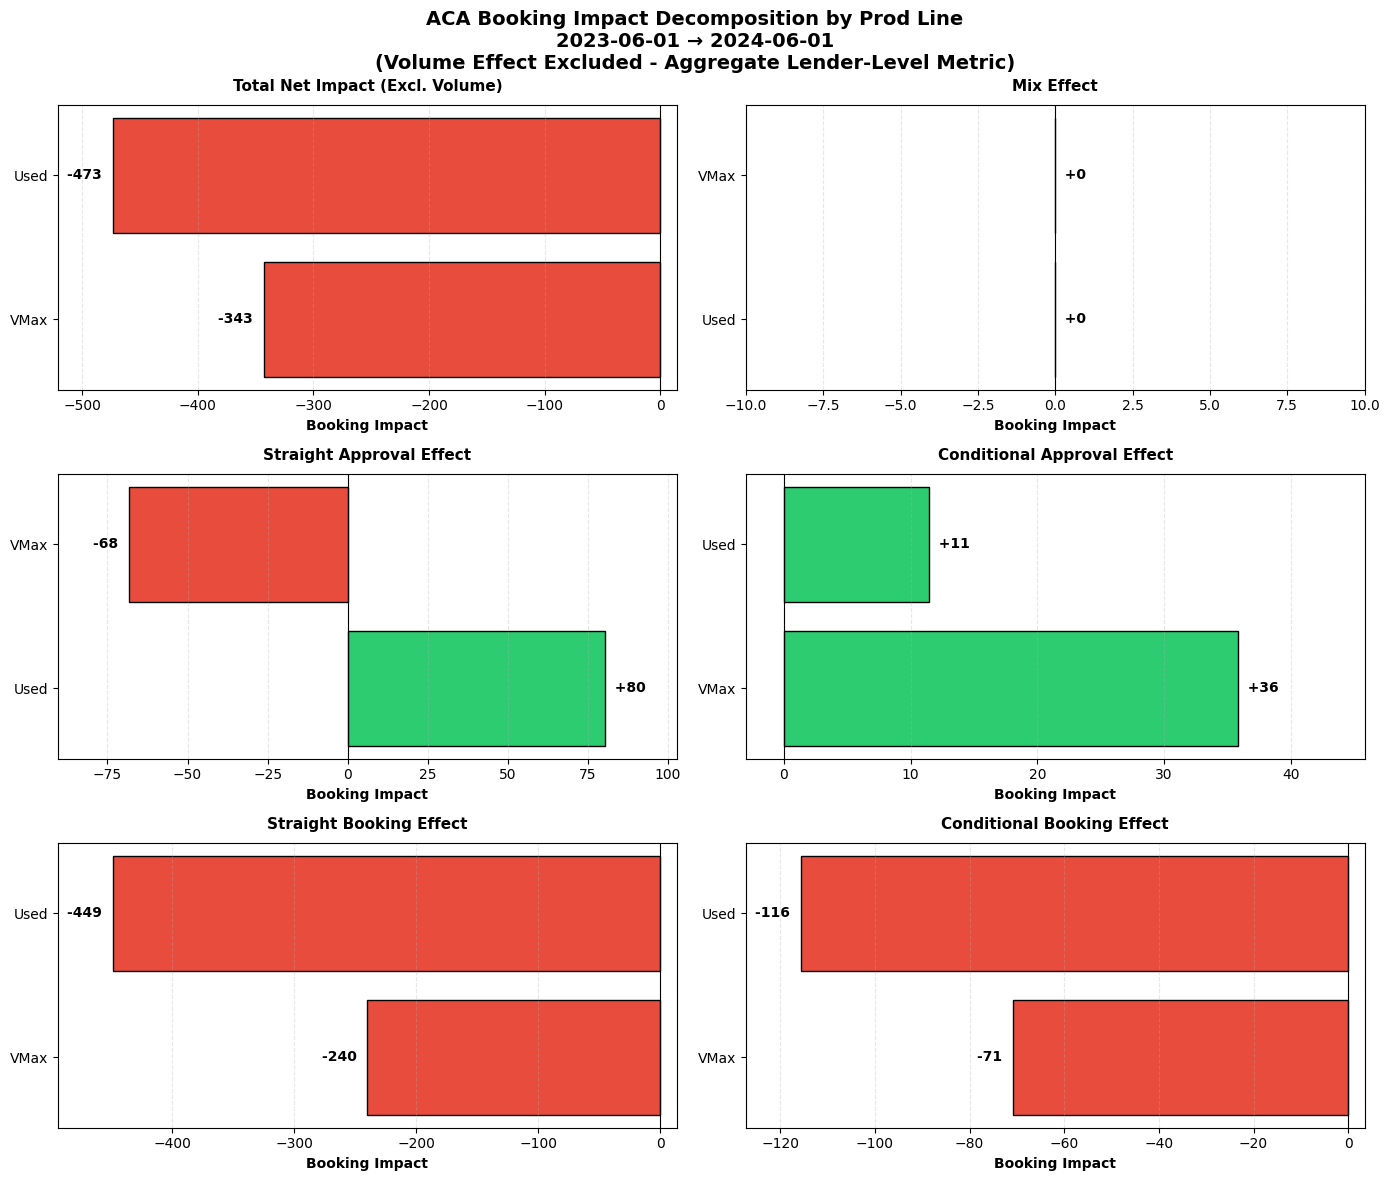

In [22]:
# Create Product Line drilldown
fig_prod = visualization_engine.create_dimension_drilldown(
    segment_detail=results_sym.segment_detail,
    dimension='prod_line',
    lender='ACA'
)

plt.show()

---

# 6. Segment-Level Detail

## Detailed Segment Analysis

All decomposition results include segment-level detail showing:
- Period 1 and Period 2 metrics for each segment
- Delta values for all metrics
- Individual effect contributions by segment

This is useful for:
- Identifying specific segments driving changes
- Deep-dive analysis of particular dimension combinations
- Validation of aggregate results

In [23]:
# Show segment-level detail (first 10 segments)
print("Segment-Level Detail (First 10 Segments):")
results_sym.segment_detail.head(10)

Segment-Level Detail (First 10 Segments):


,fico_bands,offer_comp_tier,prod_line,period_1_date,period_1_total_apps,period_1_pct_of_total,period_1_segment_apps,period_1_str_apprv_rate,period_1_str_bk_rate,period_1_cond_apprv_rate,...,delta_cond_bk_rate,delta_segment_bookings,volume_effect,mix_effect,str_approval_effect,cond_approval_effect,str_booking_effect,cond_booking_effect,interaction_effect,total_effect
0,High_FICO,multi_best,Used,2023-06-01,14573,0.119658,1743.777778,0.505422,0.644748,0.244578,...,-0.031075,46.227733,129.232883,0.0,15.245495,15.090364,-97.870665,-15.290826,-0.179519,46.227733
1,High_FICO,multi_best,VMax,2023-06-01,14573,0.076923,1121.000000,0.556486,0.714620,0.225156,...,-0.089180,-75.897320,87.702572,0.0,-34.683095,4.685214,-108.544817,-25.393638,0.336446,-75.897320
2,High_FICO,multi_other,Used,2023-06-01,14573,0.064103,934.166667,0.476437,0.681085,0.223563,...,0.004178,-8.726671,63.092863,0.0,-12.546784,5.669966,-66.070742,0.999511,0.128515,-8.726671
3,High_FICO,multi_other,VMax,2023-06-01,14573,0.038462,560.500000,0.466906,0.639702,0.233094,...,-0.056623,26.223321,39.208103,0.0,-0.717696,5.302792,-8.894696,-8.631041,-0.044140,26.223321
4,High_FICO,solo_offer,Used,2023-06-01,14573,0.145299,2117.444444,0.481621,0.649635,0.262995,...,-0.020158,79.113264,155.452518,0.0,76.958463,-27.260855,-114.165308,-11.407162,-0.464392,79.113264
5,High_FICO,solo_offer,VMax,2023-06-01,14573,0.094017,1370.111111,0.512601,0.678012,0.228853,...,-0.058590,3.069680,104.907456,0.0,-48.193022,16.951735,-49.063838,-21.622767,0.090116,3.069680
6,Low_FICO,multi_best,Used,2023-06-01,14573,0.031624,460.855556,0.296911,0.392057,0.403089,...,-0.042148,4.708794,15.865071,0.0,-4.485950,1.818622,0.358979,-8.825529,-0.022398,4.708794
7,Low_FICO,multi_best,VMax,2023-06-01,14573,0.015385,224.200000,0.350448,0.420926,0.349552,...,0.011432,0.068258,8.599455,0.0,-7.252364,3.976632,-6.427465,1.091711,0.080289,0.068258
8,Low_FICO,multi_other,Used,2023-06-01,14573,0.015385,224.200000,0.278216,0.428851,0.421784,...,0.045511,8.766217,8.278487,0.0,-2.843718,1.349909,-2.924569,4.878219,0.027890,8.766217
9,Low_FICO,multi_other,VMax,2023-06-01,14573,0.007692,112.100000,0.249711,0.466565,0.450289,...,-0.076668,-1.377308,4.373442,0.0,0.629128,-0.294144,-1.898676,-4.188088,0.001029,-1.377308


In [24]:
# Example: Find top 5 segments by total effect
top_segments = results_sym.segment_detail.nlargest(5, 'total_effect')[[
    'fico_bands', 'offer_comp_tier', 'prod_line', 
    'period_1_segment_bookings', 'period_2_segment_bookings', 'total_effect'
]]

print("\nTop 5 Segments by Positive Impact:")
print(top_segments.to_string(index=False))


Top 5 Segments by Positive Impact:
fico_bands offer_comp_tier prod_line  period_1_segment_bookings  period_2_segment_bookings  total_effect
 High_FICO      solo_offer      Used                 837.814786                 916.928050     79.113264
 High_FICO      multi_best      Used                 706.579219                 752.806952     46.227733
  Med_FICO      solo_offer      VMax                 210.272870                 252.278763     42.005893
 High_FICO     multi_other      VMax                 208.865588                 235.088909     26.223321
  Med_FICO      multi_best      VMax                 139.811515                 151.034788     11.223273


---

# 7. Exporting Results

## Export to CSV

All results can be easily exported using pandas:

In [25]:
# Export examples (uncomment to use)
# results_sym.summary.to_csv('symmetric_summary.csv', index=False)
# results_sym.segment_detail.to_csv('symmetric_segment_detail.csv', index=False)
# results_hier.summary.to_csv('hierarchical_summary.csv', index=False)
# results_multi.aggregate_summary.to_csv('multi_lender_aggregate.csv', index=False)

## Export Charts to PNG

See the **`chart_export.ipynb`** notebook for detailed examples of:
- Extracting individual charts from grids
- Exporting charts as PNG files
- Batch export functionality
- Organized directory structure for exports

---

# Summary

## Key Takeaways

### 1. **Multiple Methodologies**
- **Symmetric**: Order-independent, balanced, includes interaction effect
- **Hierarchical**: Sequential waterfall, step-by-step logic
- Both methods produce perfect reconciliation to actual booking changes

### 2. **Flexible Time Granularity**
- Monthly analysis (default: `date_column='month_begin_date'`)
- Weekly analysis (use: `date_column='week_begin_date'`)
- Any custom date column supported

### 3. **Multi-Lender Capabilities**
- Aggregate view across all lenders
- Lender attribution for each effect
- Side-by-side comparisons

### 4. **Rich Visualizations**
- Waterfall grids (2×2 dimensional breakdowns)
- Dimensional stacked waterfalls
- Dimension drilldown charts
- Multi-lender comparison charts
- All using shared visualization engine

### 5. **Detailed Analytics**
- Segment-level detail for deep dives
- Effect attribution by dimension
- Export capabilities for further analysis

## When to Use Each Method

**Use Symmetric when:**
- You want order-independent results
- Comparing multiple decompositions
- Balanced view is important
- Need consistent methodology across analyses

**Use Hierarchical when:**
- Sequential logic matches business process
- Explaining step-by-step transformations
- Traditional waterfall approach is preferred

**Use Weekly when:**
- Need higher frequency monitoring
- Faster detection of trends
- Operational decision-making cycles

**Use Multi-Lender when:**
- Portfolio-level analysis
- Lender comparison and benchmarking
- Strategic resource allocation
- Distinguishing systematic vs lender-specific issues